In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [5]:
DATA_DIR = "../data"

ID_COLUMN = 'Id'
TARGET_COLUMN = 'Response'

SEED = 0
CHUNKSIZE = 50000
NROWS = 250000

In [6]:
TRAIN_NUMERIC = "{0}/train_numeric.csv".format(DATA_DIR)
TRAIN_DATE = "{0}/train_date.csv".format(DATA_DIR)

TEST_NUMERIC = "{0}/test_numeric.csv".format(DATA_DIR)
TEST_DATE = "{0}/test_date.csv".format(DATA_DIR)

FILENAME = "etimelhoods"

In [7]:
train = pd.read_csv(TRAIN_NUMERIC, usecols=[ID_COLUMN, TARGET_COLUMN], nrows=NROWS)
test = pd.read_csv(TEST_NUMERIC, usecols=[ID_COLUMN], nrows=NROWS)

In [8]:
train["StartTime"] = -1
test["StartTime"] = -1

In [9]:
nrows = 0
for tr, te in zip(pd.read_csv(TRAIN_DATE, chunksize=CHUNKSIZE), pd.read_csv(TEST_DATE, chunksize=CHUNKSIZE)):
    feats = np.setdiff1d(tr.columns, [ID_COLUMN])

    stime_tr = tr[feats].min(axis=1).values
    stime_te = te[feats].min(axis=1).values

    train.loc[train.Id.isin(tr.Id), 'StartTime'] = stime_tr
    test.loc[test.Id.isin(te.Id), 'StartTime'] = stime_te

    nrows += CHUNKSIZE
    if nrows >= NROWS:
        break

In [10]:
ntrain = train.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True).reset_index(drop=False)

train_test['0_¯\_(ツ)_/¯_1'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
train_test['0_¯\_(ツ)_/¯_2'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

train_test = train_test.sort_values(by=['StartTime', 'Id'], ascending=True)

train_test['0_¯\_(ツ)_/¯_3'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
train_test['0_¯\_(ツ)_/¯_4'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

train_test = train_test.sort_values(by=['index']).drop(['index'], axis=1)
train = train_test.iloc[:ntrain, :]

In [11]:
features = np.setdiff1d(list(train.columns), [TARGET_COLUMN, ID_COLUMN])

In [12]:
y = train.Response.ravel()
train = np.array(train[features])

print('train: {0}'.format(train.shape))
prior = np.sum(y) / (1.*len(y))

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 2,
    'eval_metric': 'auc',
    'base_score': prior
}


train: (250000, 5)


In [13]:
dtrain = xgb.DMatrix(train, label=y)
res = xgb.cv(xgb_params, dtrain, num_boost_round=10, nfold=4, seed=0, stratified=True,
             early_stopping_rounds=1, verbose_eval=1, show_stdv=True)

cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))

TypeError: __init__() got an unexpected keyword argument 'n_splits'

In [3]:
#try with matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

<IPython.core.display.Javascript object>


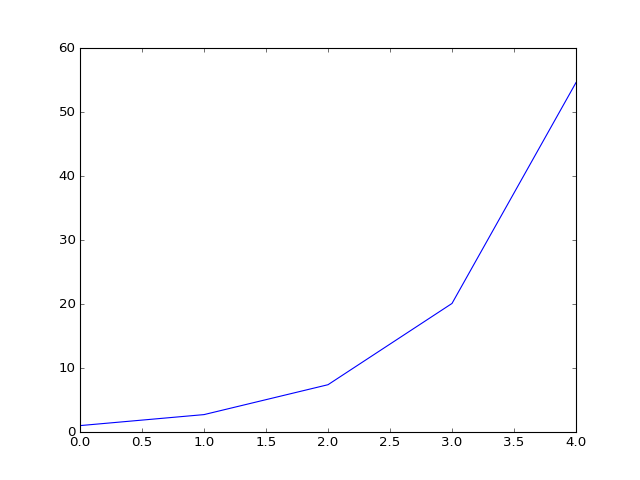

In [4]:
x = np.arange(5)
y = np.exp(x)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(x, y)

<IPython.core.display.Javascript object>


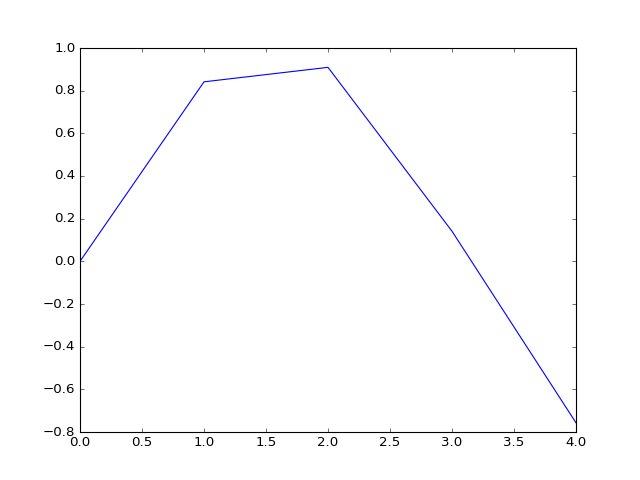

In [5]:
z = np.sin(x)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(x, z)